# Load Models and Data

In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import pandas as pd
pd.set_option("display.max_columns", 500)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, auc, roc_curve
from sklearn.model_selection import KFold

In [ ]:
from utils import *

In [17]:
def get_auc(results, y_test, y_pred):
    y_pred_proba = results.predict_proba(X_test)
    y_pred_proba_1 = [x[1] for x in y_pred_proba]
    pr = roc_curve(y_test, y_pred_proba_1)
    return auc(pr[0], pr[1])

In [18]:
from utils import cost_function, coster, get_scores

In [2]:
conn = sqlite3.connect("eia")
cursor = conn.cursor()
df = pd.DataFrame(cursor.execute("""select * from combined5""").fetchall())
df.columns = [description[0] for description in cursor.description]
df = df.drop(columns=["index", "level_0"])
df.head()

,average_ash_content,average_heat_content,average_mercury_content,average_sulfur_content,chlorine_content,coalmine_county,coalmine_msha_id,coalmine_name,coalmine_state,coalmine_type,contract_expiration_date,contract_type,energy_source,fuel_cost,fuel_group,moisture_content,month,natural_gas_delivery_contract_type,natural_gas_supply_contract_type,natural_gas_transportation_service,operator_id,operator_name,plant_id,plant_name,plant_state,primary_transportation_mode,purchase_type,quantity,regulated,reporting_frequency,secondary_transportation_mode,supplier,year,plant_id_gen,combined_heat_and_power_plant,plant_name_gen,operator_name_gen,state_gen,census_region,nerc_region,reserved_,naics_code,eia_sector_number,sector_name,reported_prime_mover,reported_fuel_type_code,aer_fuel_type_code,reserved_1,reserved_2,physical_unit_label,total_fuel_consumption_quantity,electric_fuel_consumption_quantity,total_fuel_consumption_mmbtu,elec_fuel_consumption_mmbtu,net_generation_megawatthours,year_gen,quantity_gen,elec_quantity_gen,mmbtu_per_unit_gen,tot_mmbtu_gen,elec_mmbtu_gen,netgen_gen,year_month_nerc,number_affected,disturbance_events
0,5.4,23.100,0.0,0.49,0.0,IMP,N/A,MINA PRIBBENOW,CL,SU,408.0,C,BIT,213.5,Coal,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,RV,N/A,259412,REG,M,N/A,INTEROCEAN COAL,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,ST,BIT,COL,None,None,short tons,4208251,4208251,94561606,94561606,9472859,2008,340778,340778,22.59,7697153,7697153,778699,2008-1-SERC,0.0,0.0
1,5.7,22.800,0.0,0.48,0.0,IMP,N/A,MINA PRIBBENOW,CL,SU,408.0,C,BIT,211.5,Coal,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,RV,N/A,52241,REG,M,N/A,INTEROCEAN COAL,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,ST,BIT,COL,None,None,short tons,4208251,4208251,94561606,94561606,9472859,2008,340778,340778,22.59,7697153,7697153,778699,2008-1-SERC,0.0,0.0
2,0.0,1.039,0.0,0.00,0.0,N/A,N/A,None,N/A,N/A,None,C,NG,863.1,Natural Gas,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,PL,N/A,2783619,REG,M,N/A,BAY GAS PIPELINE,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,CA,NG,NG,None,None,mcf,3433,3433,3559,3559,1609033,2008,2400,2400,1.04,2489,2489,146327,2008-1-SERC,0.0,0.0
3,0.0,1.039,0.0,0.00,0.0,N/A,N/A,None,N/A,N/A,None,C,NG,863.1,Natural Gas,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,PL,N/A,2783619,REG,M,N/A,BAY GAS PIPELINE,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,CT,NG,NG,None,None,mcf,30932077,30932077,32090118,32090118,2858195,2008,2781102,2781102,1.04,2884003,2884003,244784,2008-1-SERC,0.0,0.0
4,0.0,1.039,0.0,0.00,0.0,N/A,N/A,None,N/A,N/A,None,C,NG,863.1,Natural Gas,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,PL,N/A,2783619,REG,M,N/A,BAY GAS PIPELINE,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,ST,NG,NG,None,None,mcf,837652,837652,871270,871270,87265,2008,109281,109281,1.04,113543,113543,11487,2008-1-SERC,0.0,0.0


In [222]:
df.shape

(440666, 65)

In [3]:
ng_fields = [ 'contract_type', 'fuel_cost', 'fuel_group', 'operator_id',  'plant_id', 'plant_state', 'primary_transportation_mode', 'purchase_type', 'quantity', 'regulated', "reporting_frequency", "secondary_transportation_mode", "supplier", "combined_heat_and_power_plant", "nerc_region", "reported_prime_mover", "mmbtu_per_unit_gen", "disturbance_events", "number_affected", "net_generation_megawatthours"]

# Checking Correlations

In [223]:
df_ng.shape

(268454, 1708)

In [6]:
# Label encode categorical fields so that they can be correlated
df_ng = df[df["fuel_group"] == "Natural Gas"][ng_fields]
not_encode = []
to_encode = []
for fld, fld_type in df_ng[ng_fields].dtypes.items():
    if "object" == fld_type:
        to_encode.append(fld)
    else:
        not_encode.append(fld)
le = LabelEncoder()
temp1 = df_ng[not_encode].reset_index()
temp2 = df_ng[to_encode].apply(le.fit_transform).reset_index()
df_ng = temp1.merge(temp2, on="index").set_index("index")

In [7]:
corr = df_ng.corr()

In [8]:
corrs = []
for col in corr.columns:
    top_3 = corr[col].sort_values(ascending=False)[1:6]        
    for val in top_3.index:
        corrs.append([col, val, top_3[val]])

corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
corrs[0:20]  

[['natural_gas_delivery_contract_type',
  'natural_gas_supply_contract_type',
  0.9949670257245146],
 ['natural_gas_supply_contract_type',
  'natural_gas_delivery_contract_type',
  0.9949670257245146],
 ['disturbance_events', 'number_affected', 0.7655082998226197],
 ['number_affected', 'disturbance_events', 0.7655082998226197],
 ['mmbtu_per_unit_gen', 'reported_prime_mover', 0.4551813724903194],
 ['natural_gas_transportation_service', 'purchase_type', 0.375298202366619],
 ['purchase_type', 'natural_gas_transportation_service', 0.375298202366619],
 ['contract_type', 'natural_gas_delivery_contract_type', 0.35006057060938583],
 ['natural_gas_delivery_contract_type', 'contract_type', 0.35006057060938583],
 ['contract_type', 'natural_gas_supply_contract_type', 0.34927582099496446],
 ['natural_gas_supply_contract_type', 'contract_type', 0.34927582099496446],
 ['primary_transportation_mode', 'purchase_type', 0.2942462825380524],
 ['purchase_type', 'primary_transportation_mode', 0.294246282538

Some obvious correlations in here, like gas supply and delivery contract type or disturbance events and number affected (by disturbance events). It helps give an idea of the data, btu it doesn't indicate any changes to features.

### Checking Correlations Involving Fuel Cost

In [9]:
corrs = []
for col in corr.columns:
    top_3 = corr[col].sort_values(ascending=False)[1:]       
    for val in top_3.index:
        if col == "fuel_cost" or val == "fuel_cost":
            corrs.append([col, val, top_3[val]])

corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
corrs[0:20]  

[['fuel_cost', 'number_affected', 0.016547105838107864],
 ['fuel_cost', 'regulated', nan],
 ['number_affected', 'fuel_cost', 0.016547105838107864],
 ['fuel_cost', 'disturbance_events', 0.008163806819898293],
 ['disturbance_events', 'fuel_cost', 0.008163806819898293],
 ['fuel_cost', 'reporting_frequency', 0.005495275823372207],
 ['reporting_frequency', 'fuel_cost', 0.005495275823372207],
 ['fuel_cost', 'nerc_region', 0.00423735556784291],
 ['nerc_region', 'fuel_cost', 0.00423735556784291],
 ['fuel_cost', 'plant_id', 0.003095974637123335],
 ['plant_id', 'fuel_cost', 0.003095974637123335],
 ['fuel_cost', 'primary_transportation_mode', 0.002930004254140046],
 ['primary_transportation_mode', 'fuel_cost', 0.002930004254140046],
 ['fuel_cost', 'supplier', 0.00274519529513206],
 ['supplier', 'fuel_cost', 0.00274519529513206],
 ['fuel_cost', 'natural_gas_supply_contract_type', 0.0006275626240884574],
 ['natural_gas_supply_contract_type', 'fuel_cost', 0.0006275626240884574],
 ['fuel_cost', 'natu

Interesting that disturbance events and number affected are correlated to fuel cost, but the correlation is not high. Same for other correlations: interesting but not strong enough to infer anything. On to modelling.

In [299]:
df.columns

Index(['average_ash_content', 'average_heat_content',
       'average_mercury_content', 'average_sulfur_content', 'chlorine_content',
       'coalmine_county', 'coalmine_msha_id', 'coalmine_name',
       'coalmine_state', 'coalmine_type', 'contract_expiration_date',
       'contract_type', 'energy_source', 'fuel_cost', 'fuel_group',
       'moisture_content', 'month', 'natural_gas_delivery_contract_type',
       'natural_gas_supply_contract_type',
       'natural_gas_transportation_service', 'operator_id', 'operator_name',
       'plant_id', 'plant_name', 'plant_state', 'primary_transportation_mode',
       'purchase_type', 'quantity', 'regulated', 'reporting_frequency',
       'secondary_transportation_mode', 'supplier', 'year', 'plant_id_gen',
       'combined_heat_and_power_plant', 'plant_name_gen', 'operator_name_gen',
       'state_gen', 'census_region', 'nerc_region', 'reserved_', 'naics_code',
       'eia_sector_number', 'sector_name', 'reported_prime_mover',
       'reported_fu

# Modelling

In [4]:
def get_ng():
    df_ng = df[ng_fields]
    not_encode = []
    to_encode = []
    for fld, fld_type in df_ng[ng_fields].dtypes.items():
        if "object" == fld_type:
            to_encode.append(fld)
        else:
            not_encode.append(fld)
    temp1 = df_ng[not_encode].reset_index()
    temp2 = pd.get_dummies(df_ng[to_encode]).reset_index()
    df_ng = temp1.merge(temp2, on="index").set_index("index")
    return df_ng

In [5]:
def get_xy():
    X = df_ng.drop(columns=["fuel_cost"])
    y = (df_ng.fuel_cost > df_ng.fuel_cost.quantile(.9))
    return X, y

## Train-Test Split

In [54]:
df_ng = get_ng()
X, y = get_xy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

In [55]:
results.score(X_test, y_test)

0.9670047881634783

Decent score for accuracy, indicating better than baseline == "no price spikes" for the imbalanced model (p=.9). But f1 score will be the better determinant.

In [56]:
y_pred = results.predict(X_test)
get_scores(y_test, y_pred, X_test)

       0     1
0  78716   547
1   2361  6510
Precision: 0.922488309479949
Recall: 0.7338518769022658
F1: 0.8174284279256656
Cost Function: -0.02124396458814257


{'precision': 0.922488309479949,
 'recall': 0.7338518769022658,
 'f1': 0.8174284279256656,
 'cost': -0.02124396458814257,
 'accuracy': 0.9670047881634783}

Great precision and accuracy, decent recall and f1, ok cost-benefit. Lots of true positives.

## ROC Curve

In [29]:
y_pred_proba = results.predict_proba(X_test)

In [30]:
y_pred_proba_1 = [x[1] for x in y_pred_proba]

In [31]:
pr = roc_curve(y_test, y_pred_proba_1)

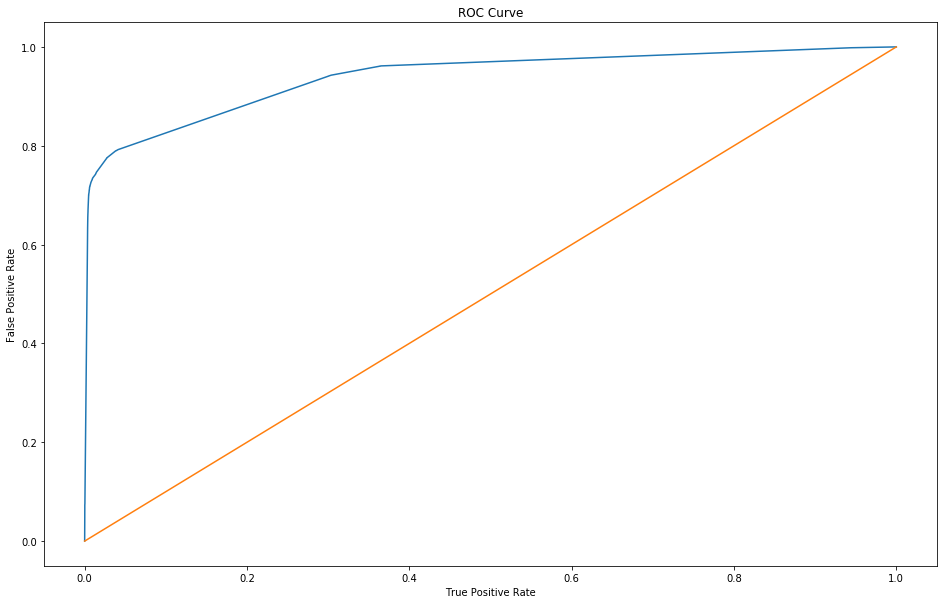

In [32]:
fig = plt.figure(figsize=(16,10))
plt.title("ROC Curve")
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.plot(pr[0], pr[1])
plt.plot(pr[0],pr[0])

In [33]:
auc(pr[0], pr[1])

0.939084874500289

Good roc and better auc.

## K Folds

In [34]:
df_ng = get_ng()
X, y = get_xy()

In [44]:
scores = []
folds = KFold(n_splits=5)
for train_index, test_index in folds.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = DecisionTreeClassifier(random_state=23, max_depth=10)
    y_pred = model.fit(X_train, y_train).predict(X_test)
    scores.append(get_scores(y_test, y_pred, X_test))

       0     1
0  72496  1373
1   8194  6071
Precision: 0.8155561526061257
Recall: 0.4255871012968805
F1: 0.5593071997788935
Cost Function: -0.1513891709078385
       0     1
0  80028   254
1   1702  6149
Precision: 0.9603310947993128
Recall: 0.7832123296395364
F1: 0.8627753613020905
Cost Function: -0.005755387067989918
       0     1
0  80395  1054
1   1482  5202
Precision: 0.8315217391304348
Recall: 0.7782764811490126
F1: 0.8040185471406492
Cost Function: -0.004433382457820857
       0     1
0  79985   155
1   1342  6651
Precision: 0.9772259770790479
Recall: 0.8321030902039285
F1: 0.8988445165213866
Cost Function: -0.003249135437208572
       0     1
0  80576   286
1   1324  5947
Precision: 0.9541151933258463
Recall: 0.8179067528538028
F1: 0.8807760663507109
Cost Function: -0.005179212810703251


In [46]:
for fld in ["precision", "recall", "f1", "cost", "accuracy"]:
    print(fld, np.mean([x[fld] for x in scores]))

precision 0.9077500313881532
recall 0.727417151028632
f1 0.8011443382187462
cost -0.03400125773631221
accuracy 0.9610454847800849


In [48]:
df[df["supplier"] == "PACIFIC BIODIESEL"].fuel_group.head()

107847    Petroleum
107848    Petroleum
107849    Petroleum
109803    Petroleum
109804    Petroleum
Name: fuel_group, dtype: object

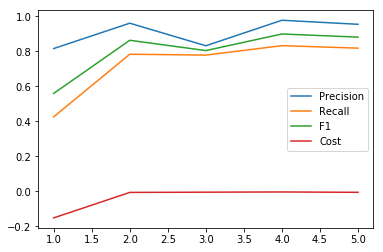

In [38]:
xs = list(range(1,6))
plt.plot(xs, [x["precision"] for x in scores], label="Precision")
plt.plot(xs, [x["recall"] for x in scores], label="Recall")
plt.plot(xs, [x["f1"] for x in scores], label="F1")
plt.plot(xs, [x["cost"] for x in scores], label="Cost")
plt.legend()

In [ ]:
Consistent scores across kfolds validation.

## Analyzing Results of Subsets

When the delivery contract isn't unknown or empty, the model doesn't add much benefit, but that's also because there are few price spikes altogether. And the precision is very good.

In [211]:
df_ng=get_ng()
df_ng3 = df_ng[(df_ng["natural_gas_delivery_contract_type_N/A"] == 1)]

X = df_ng3.drop(columns="fuel_cost")
y = (df_ng3.fuel_cost > df_ng.fuel_cost.quantile(.8))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

In [212]:
y_pred = results.predict(X_test)
get_scores(y_test, y_pred, X_test)

Precision: 0.7195068251871423
Recall: 0.32950191570881227
F1: 0.4520055325034578
       0     1
0  30328  1274
1   6650  3268
Cost Function: -0.09547856488281592


Very good scores here. 

In [213]:
get_auc(results, y_test, y_pred)

0.8111649696232606

In [133]:
cross_val_score(results, X, y, scoring=coster, cv=5)

Precision: 0.26490683229813666
Recall: 0.5960866526904263
F1: 0.3668028380993335
       0      1
0  14934  16569
1   4046   5971
Cost Function: -0.11065152058331133
       0      1
0  14934  16569
1   4046   5971
Precision: 0.8347076461769115
Recall: 0.22232205251073175
F1: 0.3511233740638549
       0     1
0  31062   441
1   7790  2227
Cost Function: -0.04016438171107114
       0     1
0  31062   441
1   7790  2227
Precision: 0.8293203291679366
Recall: 0.27163821503444147
F1: 0.40923447134907504
       0     1
0  30943   560
1   7296  2721
Cost Function: -0.11907093627851568
       0     1
0  30943   560
1   7296  2721
Precision: 0.2129032258064516
Recall: 0.11200958370769691
F1: 0.14679139137829528
       0     1
0  27355  4148
1   8895  1122
Cost Function: -0.026741629798990217
       0     1
0  27355  4148
1   8895  1122
Precision: 0.7205683355886333
Recall: 0.21263851452530697
F1: 0.32837431588684185
       0     1
0  30676   826
1   7887  2130
Cost Function: -0.15438196567760298


array([-0.11065152, -0.04016438, -0.11907094, -0.02674163, -0.15438197])

In [227]:
np.mean([-0.11065152, -0.04016438, -0.11907094, -0.02674163, -0.15438197])

-0.090202088

In [228]:
282/5

56.4

Some bad scores in there, but cost function is generally very good. 

Maybe quantities are low when it's inaccurate?

In [316]:
leaf2_pred = y_pred
leaf2_test = y_test

In [6]:
df_ng = get_ng()
X, y = get_xy()

model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X, y)

In [7]:
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True)[0:50]:
    print(a,b)

fuel_group_Petroleum 0.885709664886966
quantity 0.02557913257106861
net_generation_megawatthours 0.014444658977084938
primary_transportation_mode_N/A 0.007276981736875452
plant_id_56328 0.006325001909949166
supplier_LG&E 0.005478624151072916
mmbtu_per_unit_gen 0.005392978493075606
operator_id_19876.0 0.005330149077199097
plant_id_141 0.004582548838900955
plant_id_8219 0.0032839565443755613
nerc_region_NPCC 0.002956176705284717
plant_state_NY 0.0026710464452340743
disturbance_events 0.00210524281177579
number_affected 0.001657727583111565
plant_state_OK 0.0015170157325155005
nerc_region_N/A 0.0012994146006676652
supplier_POWEREX 0.0012959485113755275
plant_id_7985 0.0012956038627126515
supplier_SELF-PRODUCED 0.001271374384939658
plant_id_8073 0.0011640142771215346
plant_id_2122 0.0011086544559962205
operator_id_16534.0 0.0010570254863896881
supplier_VPSE 0.0009737420432646247
supplier_VIRGINIA POWER 0.0008945922147425063
supplier_PETROCOM 0.0008550484009022315
plant_id_7314 0.0007748473

# Tree Viz

In [40]:
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG
from IPython.display import display                               
from ipywidgets import interactive

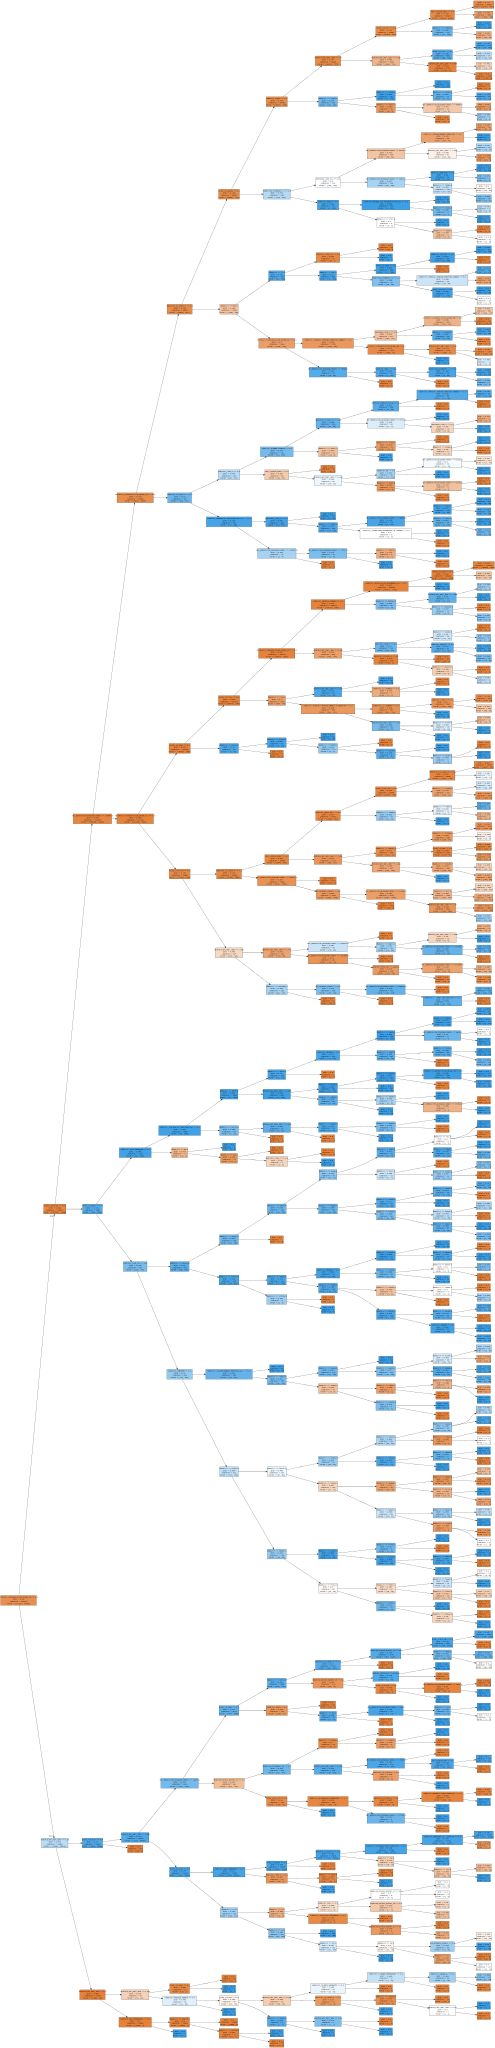

In [49]:
graph = Source(export_graphviz(results, out_file=None, rotate=True, feature_names=X.columns, filled=True))
SVG(graph.pipe(format='svg'))

In [50]:
graph.format = 'png'
graph.render('dtree_render_all2',view=True)

'dtree_render_all2.png'